This notebook contains the approach to  link prediction

(Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)



**Data: https://www.kaggle.com/competitions/FacebookRecruiting/overview/submission-instructions**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm
from scipy.sparse.linalg import svds, eigs
from xgboost import XGBClassifier
import csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
from tqdm import tqdm_notebook as tqdm
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
 train_graph=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71255  100 71255    0     0  77199      0 --:--:-- --:--:-- --:--:-- 77115


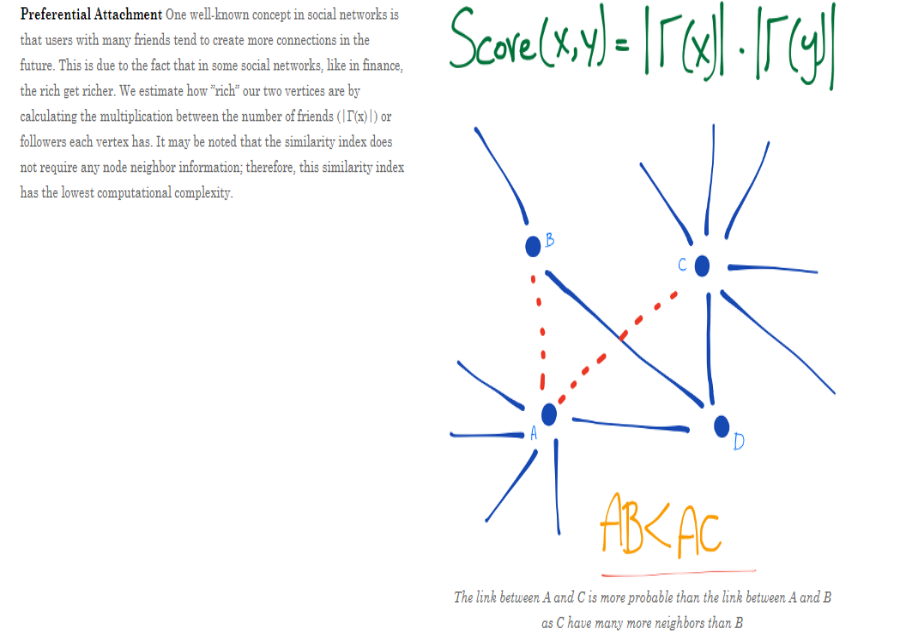

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3183  100  3183    0     0   5745      0 --:--:-- --:--:-- --:--:--  5735


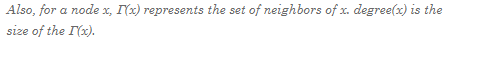

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

!curl -o pref1.png https://i.imgur.com/12J6CuL.png
img = cv2.imread('pref1.png')
ims = cv2.resize(img, (900, 640))
cv2_imshow( ims ) 

!curl -o pref2.png https://i.imgur.com/SAZCn12.png
img1 = cv2.imread('pref2.png')
cv2_imshow( img1 ) 

### Preferential Attachment

In [ ]:
def preferential_attachment(source, destination, followers_or_followees = 0):
  '''
  Input : Takes in a source , destination node, a placeholder to decide whether or not we need followers data/ followees data
  Returns their Preferential attachment score .
  '''
  try :          # If both nodes are present in the graph Run this block
    if followers_or_followees == 0:
      pref_attachment = len(set(train_graph.successors(source))) * len(set(train_graph.successors( destination)))                   # For followees
      return pref_attachment
    else:
      pref_attachment = len(set(train_graph.predecessors(source))) * len(set(train_graph.predecessors( destination)))                           # For followers    
      return pref_attachment

  except nx.NetworkXError :                               # If node is not present, catch NetworkXError and Return 0
    return 0


In [ ]:
df_final_train['Preferential_attachment_followees'] = df_final_train.apply(   lambda row :  preferential_attachment( row['source_node'], row['destination_node'], 0  )   , axis = 1  )
df_final_train['Preferential_attachment_followers'] = df_final_train.apply(   lambda row :  preferential_attachment( row['source_node'], row['destination_node'] , 1 )   , axis = 1  )

df_final_test['Preferential_attachment_followees'] = df_final_test.apply(   lambda row :  preferential_attachment( row['source_node'], row['destination_node'], 0  )   , axis = 1  )
df_final_test['Preferential_attachment_followers'] = df_final_test.apply(   lambda row :  preferential_attachment( row['source_node'], row['destination_node'] , 1 )   , axis = 1  )

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes()))
Adj = Adj.asfptype()
Adj

<1780722x1780722 sparse matrix of type '<class 'numpy.float64'>'
	with 7550015 stored elements in Compressed Sparse Row format>

In [ ]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

U, s, V = svds(Adj, k = 175)                               # Getting U,s and V matrices  , and 175 instead of 6.
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 175)
V Shape (175, 1780722)
s Shape (175,)


In [ ]:
#https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781783989485/1/ch01lvl1sec21/using-truncated-svd-to-reduce-dimensionality

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=175, n_iter=7, random_state = 2020)
svd_res = svd.fit_transform(Adj)          # Transformed 

In [ ]:
def svd_dot_of_outbound_node_and_inbound_node(source_node , destination_node, singular_matrix) :
    ''' Inputs : source_node, destination node and Singular matrix , left/ right, in case of truncated svd U *Sigma/ the transformed matrix
    Returns : the dot product between the vectors corresponding to source and destination node
    '''
    outbound_node = sadj_dict.get(  source_node )                                              # Returns None in the case of the node not found/ present
    inbound_node =  sadj_dict.get(   destination_node )                                     # Returns None in the case of the node not found/ present
    if ( outbound_node  and inbound_node ) != None :
      return ( np.dot(singular_matrix[outbound_node,:], singular_matrix[inbound_node,:]) )          # Returns the dot product of the vectors of outbound and inbound nodes
    else:
      return 0 


In [ ]:
### Appiying Dot product on U and V.T for both Train and Test data
df_final_train['svd_dot_U'] = df_final_train.apply(   lambda row :  svd_dot_of_outbound_node_and_inbound_node( row['source_node'], row['destination_node'], U )   , axis = 1  )
df_final_train['svd_dot_V'] = df_final_train.apply(   lambda row :  svd_dot_of_outbound_node_and_inbound_node( row['source_node'], row['destination_node'] , V.T )   , axis = 1  )

df_final_test['svd_dot_U'] = df_final_test.apply(   lambda row :  svd_dot_of_outbound_node_and_inbound_node( row['source_node'], row['destination_node'], U )   , axis = 1  )
df_final_test['svd_dot_V'] = df_final_test.apply(   lambda row :  svd_dot_of_outbound_node_and_inbound_node( row['source_node'], row['destination_node'] , V.T )   , axis = 1  )

In [ ]:
### Appiying Dot product on svd_res   for both Train and Test data
df_final_train['trunc_svd_dot'] = df_final_train.apply(   lambda row :  svd_dot_of_outbound_node_and_inbound_node( row['source_node'], row['destination_node'], svd_res )   , axis = 1  )
df_final_test['trunc_svd_dot'] = df_final_test.apply(   lambda row :  svd_dot_of_outbound_node_and_inbound_node( row['source_node'], row['destination_node'], svd_res )   , axis = 1  )

In [ ]:
############################################################################# Some Other Features #########################################################################################
### Degree Centrality of every node in source and destination node
#https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html

source_indegree_centrality = []                            # Lists to hold the degree and in-degree centrality
destination_indegree_centrality = []

source_degree_centrality = []
destination_degree_centrality = []

degree_centrality_dict = nx.centrality.degree_centrality(train_graph )                # Get the degree centrality  of every node
indegree_centrality_dict = nx.centrality.in_degree_centrality(train_graph )       # get indegree centrality of every node

for row in df_final_train.itertuples(index=False):
  source_degree_centrality.append(degree_centrality_dict.get(row.source_node, 0))                                       # Append degree and indegree centrality, if node is not present , append 0
  destination_degree_centrality.append(degree_centrality_dict.get(row.destination_node, 0 ))
  source_indegree_centrality.append(indegree_centrality_dict.get(row.source_node, 0))
  destination_indegree_centrality.append(indegree_centrality_dict.get(row.destination_node, 0 ))

df_final_train['src_degree_centrality'] = pd.Series(source_degree_centrality)                               # New column in train 
df_final_train['dest_degree_centrality'] = pd.Series(destination_degree_centrality)
df_final_train['src_in_degree_centrality'] = pd.Series(source_indegree_centrality)
df_final_train['dest_in_degree_centrality'] = pd.Series(destination_indegree_centrality)

source_indegree_centrality = []                          # Lists to hold the degree and in-degree centrality
destination_indegree_centrality = []
source_degree_centrality = []
destination_degree_centrality = []

for row in df_final_test.itertuples(index=False):
  source_degree_centrality.append(degree_centrality_dict.get(row.source_node, 0))                                     # Append degree and indegree centrality, if node is not present , append 0
  destination_degree_centrality.append(degree_centrality_dict.get(row.destination_node, 0 ))
  source_indegree_centrality.append(indegree_centrality_dict.get(row.source_node, 0))
  destination_indegree_centrality.append(indegree_centrality_dict.get(row.destination_node, 0 ))


df_final_test['src_degree_centrality'] = pd.Series(source_degree_centrality)                            # New column in test 
df_final_test['dest_degree_centrality'] = pd.Series(destination_degree_centrality)
df_final_test['src_in_degree_centrality'] = pd.Series(source_indegree_centrality)
df_final_test['dest_in_degree_centrality'] = pd.Series(destination_indegree_centrality)


############################################# Adding additional Truncated svd features #####################################################
def svd(x, S, n):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0] * n

df_final_train[ ['trunc_svd_' + str(i)  for i in range(175)]  ] = df_final_train.source_node.apply(lambda x: svd(x,svd_res,175 )).apply(pd.Series)
df_final_test[ ['trunc_svd_' + str(i)  for i in range(175)]  ] = df_final_train.source_node.apply(lambda x: svd(x,svd_res,175 )).apply(pd.Series)

In [ ]:
df_final_train.head(1)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,...,trunc_svd_135,trunc_svd_136,trunc_svd_137,trunc_svd_138,trunc_svd_139,trunc_svd_140,trunc_svd_141,trunc_svd_142,trunc_svd_143,trunc_svd_144,trunc_svd_145,trunc_svd_146,trunc_svd_147,trunc_svd_148,trunc_svd_149,trunc_svd_150,trunc_svd_151,trunc_svd_152,trunc_svd_153,trunc_svd_154,trunc_svd_155,trunc_svd_156,trunc_svd_157,trunc_svd_158,trunc_svd_159,trunc_svd_160,trunc_svd_161,trunc_svd_162,trunc_svd_163,trunc_svd_164,trunc_svd_165,trunc_svd_166,trunc_svd_167,trunc_svd_168,trunc_svd_169,trunc_svd_170,trunc_svd_171,trunc_svd_172,trunc_svd_173,trunc_svd_174
0,273084,1505602,1,0,0.0,0.0,0.0,6,15,8,0,0,0.0,0,1,4,0.377964,0.25,0.627964,0.094491,1.005929,0.877964,0.000002,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,0.00001,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,0.000001,1.192357e-12,...,0.000428,-0.002528,0.000449,-0.003545,-0.002676,-0.003556,0.00011,-0.000612,0.000107,0.000971,0.001716,0.000337,-0.002322,0.001284,0.000985,0.00002,-0.00001,0.000774,0.001522,0.000605,0.005465,-0.001427,0.001411,0.00245,0.00122,0.000117,-0.000888,-0.000936,0.001698,0.000841,0.004457,-0.002116,-0.00287,-0.002286,-0.005353,0.00027,0.001796,0.000795,-0.001059,-0.003965


In [ ]:
df_final_test.head(1)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,...,trunc_svd_135,trunc_svd_136,trunc_svd_137,trunc_svd_138,trunc_svd_139,trunc_svd_140,trunc_svd_141,trunc_svd_142,trunc_svd_143,trunc_svd_144,trunc_svd_145,trunc_svd_146,trunc_svd_147,trunc_svd_148,trunc_svd_149,trunc_svd_150,trunc_svd_151,trunc_svd_152,trunc_svd_153,trunc_svd_154,trunc_svd_155,trunc_svd_156,trunc_svd_157,trunc_svd_158,trunc_svd_159,trunc_svd_160,trunc_svd_161,trunc_svd_162,trunc_svd_163,trunc_svd_164,trunc_svd_165,trunc_svd_166,trunc_svd_167,trunc_svd_168,trunc_svd_169,trunc_svd_170,trunc_svd_171,trunc_svd_172,trunc_svd_173,trunc_svd_174
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,1,0,0.0,1,1,2,0.258199,0.377964,0.636163,0.09759,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,...,0.000428,-0.002528,0.000449,-0.003545,-0.002676,-0.003556,0.00011,-0.000612,0.000107,0.000971,0.001716,0.000337,-0.002322,0.001284,0.000985,0.00002,-0.00001,0.000774,0.001522,0.000605,0.005465,-0.001427,0.001411,0.00245,0.00122,0.000117,-0.000888,-0.000936,0.001698,0.000841,0.004457,-0.002116,-0.00287,-0.002286,-0.005353,0.00027,0.001796,0.000795,-0.001059,-0.003965


In [ ]:
y_train = df_final_train.indicator_link                    # Labels for y_train and y_test
y_test = df_final_test.indicator_link

In [ ]:
d_full = pd.concat((df_final_train, df_final_test), ignore_index = True)                # Stack both test and train dataframes on one another , ( useful for cross validation)

In [ ]:
d_full_labels = y_train.tolist() + y_test.tolist() 
d_full_dmatrix = xgb.DMatrix(d_full, d_full_labels)
len(df_final_test), len(df_final_train), len(d_full), len(y_train), len(y_test), len(d_full_labels)

(50002, 100002, 150004, 100002, 50002, 150004)

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)                  # drop source and dest'n nodes
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

#####  Tuning Xg boost ::

Estimators =  0.001 Train Score 0.92784486222429 test Score 0.9244079758513667
Estimators =  0.005 Train Score 0.9279512695508718 test Score 0.9244705281959683
Estimators =  0.007 Train Score 0.9289215686274511 test Score 0.9247512966584475
Estimators =  0.01 Train Score 0.9328680029100724 test Score 0.9256863162374973
Estimators =  0.03 Train Score 0.9567031498895225 test Score 0.9281150835625133
Estimators =  0.05 Train Score 0.9640180825934674 test Score 0.9285578687590963
Estimators =  0.07 Train Score 0.9685353355994114 test Score 0.9294740617286555
Estimators =  0.1 Train Score 0.9734264318963773 test Score 0.9309412112759393
Estimators =  0.2 Train Score 0.9785810988300431 test Score 0.9278245345575108
Estimators =  0.3 Train Score 0.982650922866124 test Score 0.9264314460319827


Text(0, 0.5, 'Score')

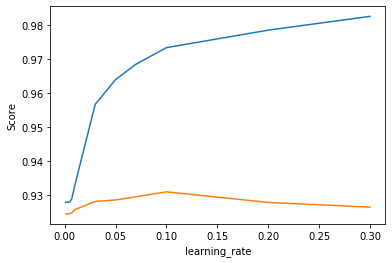

In [ ]:
##################################################### Picking n_estimators as = 50 ###############################################
################################################### Tuning the learning_rate  ##########################################################################################
learning_rates = [0.001,0.005, 0.007,  0.01,0.03, 0.05, 0.07,  0.1, 0.2, 0.3]              # Various learning rates 
train_scores = []
test_scores = []
for i in learning_rates:
    clf = xgb.XGBClassifier(n_estimators= 50,  learning_rate = i , max_depth = 5, subsample = 0.8, colsample_bytree = 0.8, gamma = 0.1 )             
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(learning_rates,train_scores,label='Train Score')
plt.plot(learning_rates,test_scores,label='Test Score')
plt.xlabel('learning_rate')
plt.ylabel('Score')

In [ ]:
# ######################################################   Tunining Max_depth  ####################################################################
# Commented because: Takes more time to get executed
#### using learning rate from previous run

# params = {  'max_depth':range(3,10,2)   }
# gb_clf = xgb.XGBClassifier(n_estimators = 50, learning_rate= 0.007, max_depth = 5, subsample = 0.8, colsample_bytree = 0.8, gamma = 0.1  )
# grid_search = GridSearchCV(estimator = gb_clf ,  param_grid=params , scoring='f1', cv=4, verbose=1, n_iter = 10)
# grid_search.fit(df_final_train, y_train)

In [ ]:
# grid_search.best_params_ 

In [ ]:
# ######################################################   Tuning gamma  ####################################################################
# Commented because: Takes more time to get executed
### Using best params from pervious run

# params = {  'gamma': [float(i/10) for i in range(0,5) ] }
# gb_clf = xgb.XGBClassifier(n_estimators = 50, learning_rate= 0.007, max_depth = 9, subsample = 0.8, colsample_bytree = 0.8, gamma = 0.1  )
# grid_search = GridSearchCV(estimator = gb_clf ,  param_grid=params , scoring='f1', cv=4, verbose=1, n_iter = 10)
# grid_search.fit(df_final_train, y_train)
# grid_search.best_params_ 

In [ ]:
# #######################################################   Tuning subsample and column by sample  ####################################################################
# Commented because: Takes more time to get executed
### Using best params from pervious run

# params = { 'subsample':[i/10.0 for i in range(6,10)],
#                     'colsample_bytree':[i/10.0 for i in range(6,10)] }

# gb_clf = xgb.XGBClassifier(n_estimators = 50, learning_rate= 0.007, max_depth = 9, subsample = 0.8, colsample_bytree = 0.8, gamma = 0.1 )
# grid_search = GridSearchCV(estimator = gb_clf ,  param_grid=params , scoring='f1', cv=4,n_iter = 10,  verbose=1)

# grid_search.fit(df_final_train, y_train)
# grid_search.best_params_ 


In [ ]:
# ######################################################   Tuning Regularization Parameters  ####################################################################
# Commented because: Takes more time to get executed
### Using best params from pervious run

# params = { 'reg_lambda' : [1e-5, 1e-2, 0.1, 1, 100]  }
# gb_clf = xgb.XGBClassifier(n_estimators = 50, learning_rate= 0.007, max_depth = 9, subsample = 0.6, colsample_bytree = 0.8, gamma = 0.2 , reg_lambda= 0.001,  n_iter = 4 )
# grid_search = GridSearchCV(estimator = gb_clf ,  param_grid=params , scoring='f1', cv=4, n_iter = 10, verbose=1)

# grid_search.fit(df_final_train, y_train)
# grid_search.best_params_ 

Text(0.5, 1.0, 'Estimators vs score')

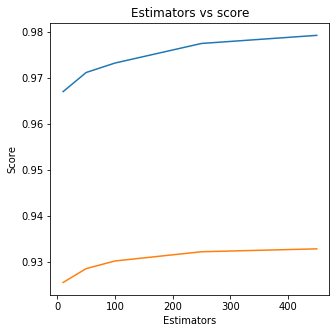

In [ ]:
########################################################### Training  for estimators again ###############################################################

estimators = [10,50,100,250,450]       # To hold the estimators
train_scores = []                                # To hold train and test scores
test_scores = []
for i in estimators:
    clf =  xgb.XGBClassifier(tree_method ='auto',  n_estimators = i, learning_rate= 0.007, max_depth = 9 , subsample = 0.8, colsample_bytree = 0.8, 
                             gamma = 0.2, colsample_bylevel= 0.8, colsample_bynode = 0.8 , reg_lambda=1e-05 , reg_alpha = 0.07)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))          # Get train and test scores and plot
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    #print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
rcParams['figure.figsize'] = 5, 5
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score')

In [ ]:
######################################################  Randomized Search CV ##################################################################################
clf = xgb.XGBClassifier()
param_grid = {
    'learning_rate': np.arange(0.05,1.05,.05),
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9 ,1.0],
    "subsample":  [0.6, 0.7, 0.8, 0.9 ,1.0],
    "max_depth": np.arange(2,15,1),
    #"n_estimators":[100,125,150,175],
    "reg_lambda": [0.1, 1, 1.5, 2],
    "gamma": [0, 0.1, 0.2, 0.3],
}
rand_search = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_grid,
    cv=5,
    scoring='f1',
    n_iter = 2
)

# fit randomsearch
best_model = rand_search.fit(df_final_train,y_train)
rand_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.2,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
# Using results from both randomsearch and gridsearch CV
#rand_search.best_estimator_

best =  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.007, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=175, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [ ]:
best.fit(df_final_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.007, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=175, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [ ]:
y_pred = best.predict(df_final_test)

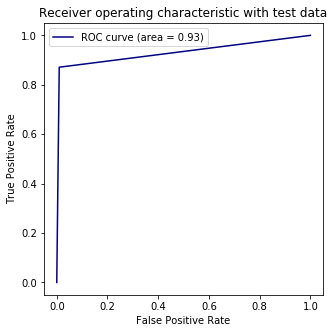

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.007, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=175, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [ ]:
clf.fit(df_final_train,y_train)                            # Training it on train and getting predictions on train and test data
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))                 # F1 score of train and test
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9284964423189083
Test f1 score 0.9261335777782514


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


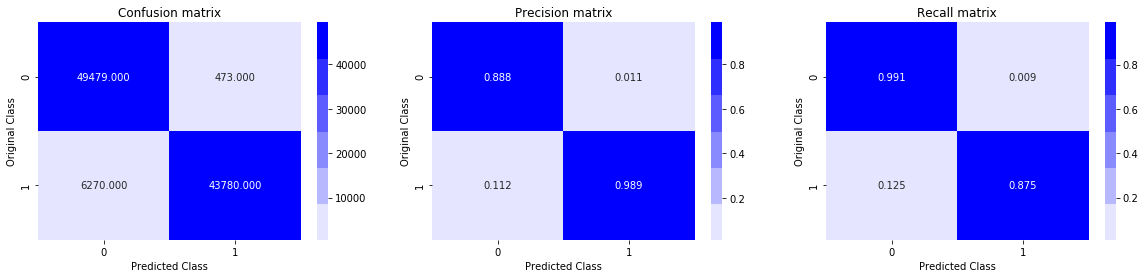

Test confusion_matrix


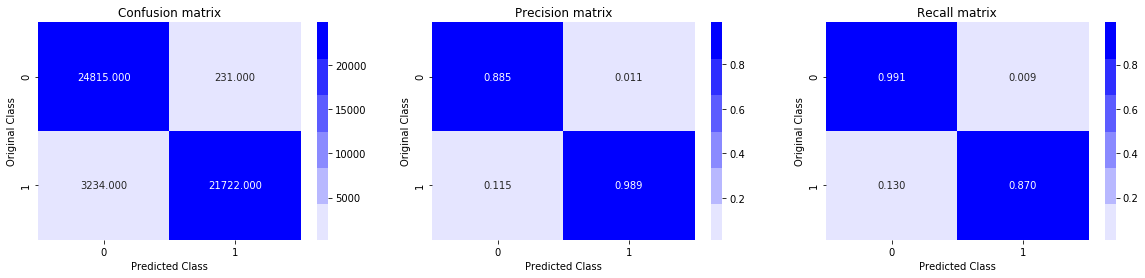

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

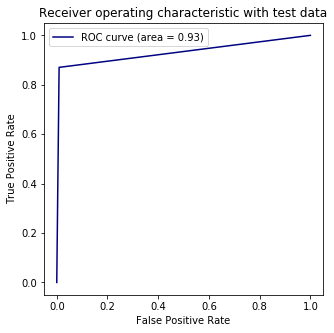

In [ ]:
from sklearn.metrics import roc_curve, auc             
fpr,tpr,ths = roc_curve(y_test,y_test_pred)              # fpr, tpr for the plots
auc_sc = auc(fpr, tpr)                             # auc score
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)  # plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

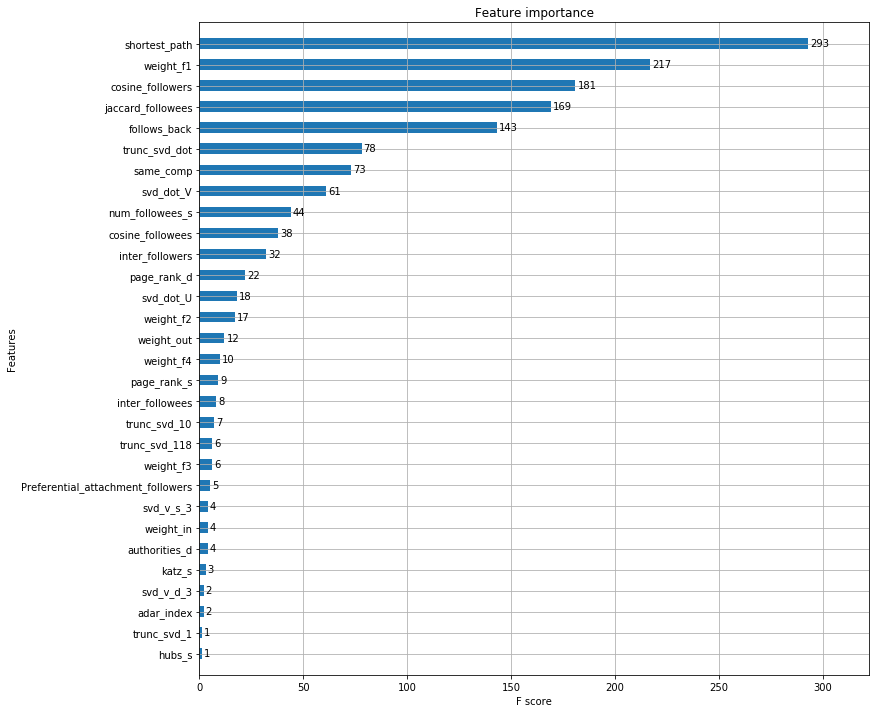

In [ ]:
# Plotting Feature importance

ax = xgb.plot_importance(clf, max_num_features = 30,height = 0.5 )            #  Plotting feature importance on f score 
fig = ax.figure 
fig.set_size_inches(12, 12)           # Increasing the size of the plot

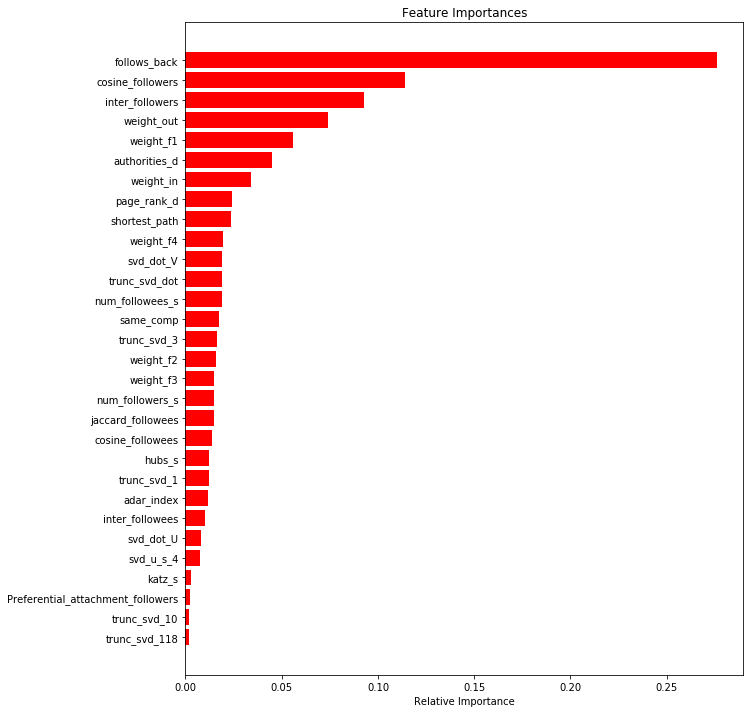

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

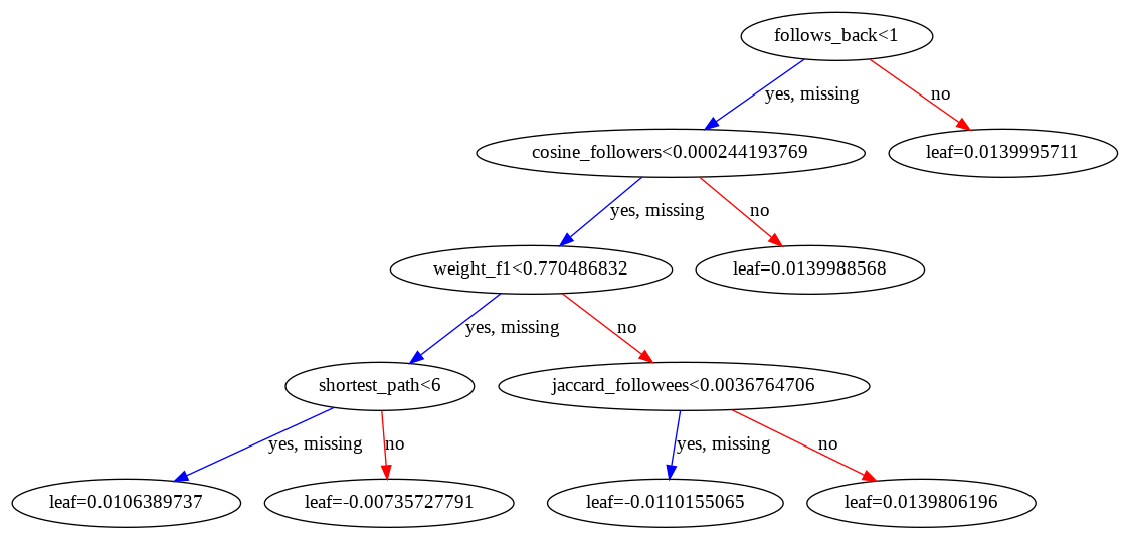

In [ ]:
########################################### To view Trees #############################################
%matplotlib inline
from xgboost import plot_tree                    # To plot the tree 0 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,20                  # adjusting figure size
plot_tree(clf, num_trees=0)                          # clf is the final classifier with best params and here the tree 0 is plotted

In [ ]:
#### To save the sample tree, which is helpful to understand splitting.
format = 'png'                                     # Format of the image to be  saved
#format = 'svg' 
image = xgb.to_graphviz(clf)            # Image
image.graph_attr = {'dpi':'400'}       # Changing dpi                    
image.render('sample_tree', format = format)        # saving the tree 0 as a png file 

'sample_tree.png'

### References Used :

1) https://www.kaggle.com/c/socialNetwork/discussion/236

2) https://www.johndcook.com/blog/2018/05/07/truncated-svd/

3) https://stackoverflow.com/questions/57136676/sklearn-model-selection-gridsearchcv-is-throwing-keyerror-mean-train-score

4) https://stackoverflow.com/questions/32894223/how-to-show-node-name-in-graphs-using-networkx

5)https://networkx.github.io/documentation/stable/reference/algorithms/generatednetworkx.algorithms.link_prediction.preferential_attachmenthtml#networkx.algorithms.link_prediction.preferential_attachment

6) https://math.stackexchange.com/questions/730511/preferential-attachment-and-salton-similarity-in-directed-networks

7) https://networkx.github.io/documentation/stable/reference/readwrite/generated/networkx.readwrite.edgelist.read_edgelist.html

8) https://stackoverflow.com/questions/30371571/networkx-how-do-i-successfully-catch-network-exception-networkxerror-when-node

9) https://stackoverflow.com/questions/55288657/image-is-not-displaying-in-google-colab-while-using-imshow

10) https://stackoverflow.com/questions/44733657/what-does-parameter-key-mean-in-dataframe-to-hdf

11) https://stackoverflow.com/questions/38460744/how-does-one-store-a-pandas-dataframe-as-an-hdf5-pytables-table-or-carray-earr

12) https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

13) https://stackoverflow.com/questions/18706863/difference-between-truncatedsvd-and-svds

14) https://thispointer.com/how-to-reverse-a-1d-2d-numpy-array-using-np-flip-and-operator-in-python/

15) https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
https://rdrr.io/cran/xgboost/man/xgb.cv.html

16) https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

17)https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

18) https://stackoverflow.com/questions/51905524/plot-importance-variables-xgboost-python

19) https://stackoverflow.com/questions/40664776/how-to-change-size-of-plot-in-xgboost-plot-importance

20) https://rdrr.io/cran/xgboost/man/xgb.plot.multi.trees.html

21) https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

22) https://stackoverflow.com/questions/58457929/saving-the-tree-from-xgboost

23) Course Taken : https://www.datacamp.com/courses/extreme-gradient-boosting-with-xgboost

24) http://be.amazd.com/link-prediction/

25) https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf

26) https://xgboost.readthedocs.io/en/latest/parameter.html#

27) https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

